In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

pd.options.display.max_colwidth = 200

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-specialization-data/Labels_Medical_Notes.csv
/kaggle/input/nlp-specialization-data/Cleaned_POS_Medical_Notes.csv
/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes/1893.txt
/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes/1711.txt
/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes/1773.txt
/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes/1812.txt
/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes/1093.txt


## Below is the model from the medical domain that has all the related words, it can be used on the used in this problem set. Its size is 800MB

In [2]:
!pip install https://med7.s3.eu-west-2.amazonaws.com/en_core_med7_lg.tar.gz

     |████████████████████████████████| 892.8 MB 8.0 kB/s eta 0:00:01    |███▏                            | 89.8 MB 1.0 MB/s eta 0:12:55     |█████▋                          | 155.9 MB 1.2 MB/s eta 0:10:12     |██████▏                         | 173.4 MB 1.2 MB/s eta 0:09:57     |████████                        | 222.4 MB 1.2 MB/s eta 0:09:13     |████████▎                       | 231.9 MB 1.2 MB/s eta 0:09:05     |███████████▍                    | 317.6 MB 1.2 MB/s eta 0:08:01��██████               | 472.7 MB 995 kB/s eta 0:07:03     |█████████████████▌              | 488.0 MB 1.0 MB/s eta 0:06:42     |████████████████████▌           | 571.7 MB 1.1 MB/s eta 0:05:03�████████▋           | 576.3 MB 948 kB/s eta 0:05:34██████████████████          | 613.8 MB 1.0 MB/s eta 0:04:36     |██████████████████████          | 614.4 MB 1.0 MB/s eta 0:04:36     |███████████████████████         | 640.9 MB 1.2 MB/s eta 0:03:34��█████████████████       | 697.0 MB 1.1 MB/s eta 0:03:07     |███████████████

## Contents

* [Read the dataset](#datasetreading)
* [Data Cleaning](#regex)
* [Stemming & Lemmatization](#stemming)
* [Tokenization](#tokenization)
* [Stop word removal](#stopword)

<a id='datasetreading'></a>

### Read the dataset

The dataset is collected from https://www.kaggle.com/c/medical-notes/data. It contains 800 anonymised transcribed medical reports with the disease category (specialty). For more information browse original source - https://www.mtsamples.com/

In [3]:
# We read all the medical notes from the directory
dir = '/kaggle/input/nlp-specialization-data/Medical_Notes/Medical_Notes'
print ("Total {} files in directory".format(len(os.listdir(dir))))

Total 1239 files in directory


## The above code has all the Medical text files and the below code has the Labels that are associated to the medical text files 

In [4]:
labels = pd.read_csv("/kaggle/input/nlp-specialization-data/Labels_Medical_Notes.csv",header=None)
labels.columns = ['file','label']

## It will get the text files and the classification given  along with it

In [5]:
labels.head(5)

,file,label
0,1001.txt,Neurology
1,1002.txt,Orthopedic
2,1003.txt,Orthopedic
3,1004.txt,Radiology
4,1005.txt,Orthopedic


## It will get the range of total files in labels.shape, The code will then go through os.path  To all the text files and then joins them.


 ### TQDM *(has to be used in range)* is used for the progess time that takes in the for loop while traversing

In [19]:
# read each medical notes and the corresponding label (disease category)
texts = []
classes = []

for i in tqdm(range(labels.shape[0])):
    
    #it will go through all the Labels file ( as have 826 only)
    
    filename = os.path.join(dir,labels.iloc[i]['file']) 
    
    # First it will join each text file ( DIR) and label with the path ( 826 among 1239 text)
    
    #it will read every line and will go join them by reading line by line - for example " ".join("Jatin","Pratap") ---> jatin pratap
    
    text = " ".join(open(filename,'r',errors='ignore').readlines())
    
    texts.append(text)
    
    classes.append(labels.iloc[i]['label'])
    
data = pd.DataFrame()
data['text'] = texts
data['label'] = classes

100%|██████████| 826/826 [00:00<00:00, 1385.42it/s]


## The above code will get the text and label in one place, In earlier case there was only text name and label type. With the above code we will be able to get the text file notes content and labels

In [7]:
print (data.shape)

(826, 2)


## For the above Medical text files, we might have 1239 files, but the classification *( lables )* for the notes is for only 826 files

In [9]:
data.head(5)

,text,label
0,\n \n \n \n \n <B>CC:</B> Difficulty with word finding.\n \n <B>HX: </B>This 27y/o RHF experienced sudden onset word finding difficulty and slurred speech on the evening of 2/19/96. She denied any...,Neurology
1,\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B> Ganglion of the left wrist.\n \n <B>POSTOPERATIVE DIAGNOSIS: </B> Ganglion of the left wrist.\n \n <B>OPERATION: </B> Excision of ganglion.\n \n <B>A...,Orthopedic
2,"\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B> Cervical myelopathy, C3-4, secondary to stenosis from herniated nucleus pulposus, C3-4.\n \n <B>POSTOPERATIVE DIAGNOSES: </B> Cervical myelopathy, C3...",Orthopedic
3,\n \n \n \n \n <B>EXAM:</B>MRI LEFT SHOULDER\n \n <B>CLINICAL:</B>This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear.\n \n <B>FINDINGS:</B>\n \n Examination was p...,Radiology
4,\n \n \n \n \n <B>HISTORY OF PRESENT ILLNESS: </B> The patient is a 57-year-old female being seen today for evaluation of pain and symptoms related to a recurrent bunion deformity in bilateral fee...,Orthopedic


<a id='regex'></a>

### Basic data cleaning

Natural language in its pure form can bring lot of noise. We need to clean the data in order to use any statistical/machine learning model. Below are the few techniques for cleaning the text data.

* Using RegEx (regular expressions) to identify the irrelevant text sections for removal
* Standardizing/normalizing texts like - abbreviations, spelling mistakes
* For social media data - remove smileys, email ids if these information are not relevant for downstream analysis


In [10]:
sample_text = data.text.iloc[3]
print (sample_text)


 
 
 
 
 <B>EXAM:</B>MRI LEFT SHOULDER
 
 <B>CLINICAL:</B>This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear.
 
 <B>FINDINGS:</B>
 
 Examination was performed on 9/1/05.
 
 There is marked supraspinatus tendinosis and extensive tearing of the substance of the tendon and articular surface, extending into the myotendinous junction as well. There is still a small rim of tendon along the bursal surface, although there may be a small tear at the level of the rotator interval. There is no retracted tendon or muscular atrophy (series #6 images #6-17).
 
 Normal infraspinatus tendon.
 
 There is subscapularis tendinosis with fraying and partial tearing of the superior most fibers extending to the level of the rotator interval (series #9 images #8-13; series #3 images #8-14). There is no complete tear, gap or fiber retraction and there is no muscular atrophy.
 
 There is tendinosis and superficial tearing of the long biceps tendon within the bicipital groove, 

In [11]:
import re

We remove all the special characters like - "\n", HTML tags from the texts

In [12]:
def remove_html(text):
    text = text.replace("\n"," ") # ALL VALUES that have the /n it will repalace 
    pattern = re.compile('<.*?>') #all the HTML tags
    return pattern.sub(r'', text)

In [13]:
sample_text_processed = remove_html(sample_text)
print (sample_text_processed)

          EXAM:MRI LEFT SHOULDER    CLINICAL:This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear.    FINDINGS:    Examination was performed on 9/1/05.    There is marked supraspinatus tendinosis and extensive tearing of the substance of the tendon and articular surface, extending into the myotendinous junction as well. There is still a small rim of tendon along the bursal surface, although there may be a small tear at the level of the rotator interval. There is no retracted tendon or muscular atrophy (series #6 images #6-17).    Normal infraspinatus tendon.    There is subscapularis tendinosis with fraying and partial tearing of the superior most fibers extending to the level of the rotator interval (series #9 images #8-13; series #3 images #8-14). There is no complete tear, gap or fiber retraction and there is no muscular atrophy.    There is tendinosis and superficial tearing of the long biceps tendon within the bicipital groove, and there is high gra

Remove all the headings from text

In [15]:
def remove_headings(text):
    pattern = re.compile('\w+:')
    return pattern.sub(r'', text)

In [16]:
sample_text_processed = remove_headings(sample_text_processed)
print (sample_text_processed)

          MRI LEFT SHOULDER    This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear.        Examination was performed on 9/1/05.    There is marked supraspinatus tendinosis and extensive tearing of the substance of the tendon and articular surface, extending into the myotendinous junction as well. There is still a small rim of tendon along the bursal surface, although there may be a small tear at the level of the rotator interval. There is no retracted tendon or muscular atrophy (series #6 images #6-17).    Normal infraspinatus tendon.    There is subscapularis tendinosis with fraying and partial tearing of the superior most fibers extending to the level of the rotator interval (series #9 images #8-13; series #3 images #8-14). There is no complete tear, gap or fiber retraction and there is no muscular atrophy.    There is tendinosis and superficial tearing of the long biceps tendon within the bicipital groove, and there is high grade (near complete) part

Remove &quot marks and other characters. Replace multiple spaces with single space

In [17]:
def replace_mult_spaces(text):
    text = text.replace("&quot","")
    pattern = re.compile(' +')
    text = pattern.sub(r' ', text)
    text = text.strip()
    return text

In [18]:
sample_text_processed = replace_mult_spaces(sample_text_processed)
print (sample_text_processed)

MRI LEFT SHOULDER This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear. Examination was performed on 9/1/05. There is marked supraspinatus tendinosis and extensive tearing of the substance of the tendon and articular surface, extending into the myotendinous junction as well. There is still a small rim of tendon along the bursal surface, although there may be a small tear at the level of the rotator interval. There is no retracted tendon or muscular atrophy (series #6 images #6-17). Normal infraspinatus tendon. There is subscapularis tendinosis with fraying and partial tearing of the superior most fibers extending to the level of the rotator interval (series #9 images #8-13; series #3 images #8-14). There is no complete tear, gap or fiber retraction and there is no muscular atrophy. There is tendinosis and superficial tearing of the long biceps tendon within the bicipital groove, and there is high grade (near complete) partial tearing of the intracapsular

remove multiple consecutive spaces and replace with single space

In [25]:
def replace_other_chars(text):
    pattern = re.compile(r'[()!@&;]')
    text = pattern.sub(r'', text)
    return text

In [26]:
sample_text_processed = replace_other_chars(sample_text_processed)
print (sample_text_processed)

MRI LEFT SHOULDER This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear. Examination was performed on 9/1/05. There is marked supraspinatus tendinosis and extensive tearing of the substance of the tendon and articular surface, extending into the myotendinous junction as well. There is still a small rim of tendon along the bursal surface, although there may be a small tear at the level of the rotator interval. There is no retracted tendon or muscular atrophy series #6 images #6-17. Normal infraspinatus tendon. There is subscapularis tendinosis with fraying and partial tearing of the superior most fibers extending to the level of the rotator interval series #9 images #8-13 series #3 images #8-14. There is no complete tear, gap or fiber retraction and there is no muscular atrophy. There is tendinosis and superficial tearing of the long biceps tendon within the bicipital groove, and there is high grade near complete partial tearing of the intracapsular portio

## Putting everything together in a function and apply the cleaning on all the texts. Further, convert everything into lower case.

In [27]:
def clean_text(text):
    text = remove_html(text)
    text = remove_headings(text)
    text = replace_mult_spaces(text)
    text = replace_other_chars(text)
    text = text.lower()
    return text

In [28]:
data['clean_text'] = data.text.apply(clean_text)

In [29]:
data

,text,label,clean_text
0,\n \n \n \n \n <B>CC:</B> Difficulty with word finding.\n \n <B>HX: </B>This 27y/o RHF experienced sudden onset word finding difficulty and slurred speech on the evening of 2/19/96. She denied any...,Neurology,"difficulty with word finding. this 27y/o rhf experienced sudden onset word finding difficulty and slurred speech on the evening of 2/19/96. she denied any associated dysphagia, diplopia, numbness ..."
1,\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B> Ganglion of the left wrist.\n \n <B>POSTOPERATIVE DIAGNOSIS: </B> Ganglion of the left wrist.\n \n <B>OPERATION: </B> Excision of ganglion.\n \n <B>A...,Orthopedic,"preoperative ganglion of the left wrist. postoperative ganglion of the left wrist. excision of ganglion. general. estimated blood less than 5 ml. after a successful anesthetic, the patient was pos..."
2,"\n \n \n \n \n <B>PREOPERATIVE DIAGNOSIS: </B> Cervical myelopathy, C3-4, secondary to stenosis from herniated nucleus pulposus, C3-4.\n \n <B>POSTOPERATIVE DIAGNOSES: </B> Cervical myelopathy, C3...",Orthopedic,"preoperative cervical myelopathy, c3-4, secondary to stenosis from herniated nucleus pulposus, c3-4. postoperative cervical myelopathy, c3-4, secondary to stenosis from herniated nucleus pulposus,..."
3,\n \n \n \n \n <B>EXAM:</B>MRI LEFT SHOULDER\n \n <B>CLINICAL:</B>This is a 69-year-old male with pain in the shoulder. Evaluate for rotator cuff tear.\n \n <B>FINDINGS:</B>\n \n Examination was p...,Radiology,mri left shoulder this is a 69-year-old male with pain in the shoulder. evaluate for rotator cuff tear. examination was performed on 9/1/05. there is marked supraspinatus tendinosis and extensive ...
4,\n \n \n \n \n <B>HISTORY OF PRESENT ILLNESS: </B> The patient is a 57-year-old female being seen today for evaluation of pain and symptoms related to a recurrent bunion deformity in bilateral fee...,Orthopedic,"history of present the patient is a 57-year-old female being seen today for evaluation of pain and symptoms related to a recurrent bunion deformity in bilateral feet, right greater than left. the ..."
...,...,...,...
821,\n \n \n \n \n \n \n \n \n \n \n \n \n,Urology,
822,"\n \n \n \n \n <B>CC:</B> Episodic mental status change and RUE numbness, and chorea (found on exam).\n \n <B>HX:</B> This 78y/o RHM was referred for an episode of unusual behavior and RUE numbnes...",Radiology,"episodic mental status change and rue numbness, and chorea found on exam. this 78y/o rhm was referred for an episode of unusual behavior and rue numbness. in 9/91, he experienced near loss of cons..."
823,"\n \n \n \n \n <B>PROCEDURE IN DETAIL: </B> Following premedication with Vistaril 50 mg and Atropine 0.4 mg IM, the patient received Versed 5.0 mg intravenously after Cetacaine spray to the poster...",Gastroenterology,"procedure in following premedication with vistaril 50 mg and atropine 0.4 mg im, the patient received versed 5.0 mg intravenously after cetacaine spray to the posterior palate. the olympus video g..."
824,\n \n \n \n \n <B>REASON FOR VISIT: </B> Overactive bladder with microscopic hematuria.\n \n <B>HISTORY OF PRESENT ILLNESS: </B> The patient is a 56-year-old noted to have microscopic hematuria wi...,Urology,reason for overactive bladder with microscopic hematuria. history of present the patient is a 56-year-old noted to have microscopic hematuria with overactive bladder. her cystoscopy performed was ...


<a id='eda'></a>

### Basic descriptive analysis on the texts

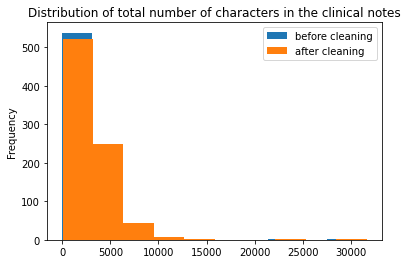

In [30]:
import matplotlib.pyplot as plt

data.clean_text.apply(len).plot.hist()
data.text.apply(len).plot.hist()
plt.title("Distribution of total number of characters in the clinical notes")
plt.legend(["before cleaning","after cleaning"])
plt.show()

## Split function returns a list of strings after dividing the string based on the given separator. The below code will get us the distrubtion of the words

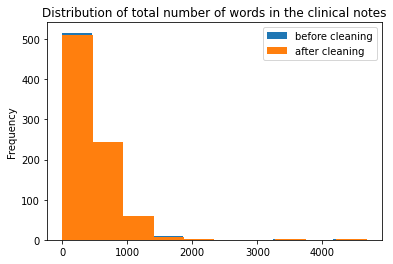

In [31]:
data.clean_text.apply(lambda x: len(x.split())).plot.hist()
data.text.apply(lambda x: len(x.split())).plot.hist()
plt.title("Distribution of total number of words in the clinical notes")
plt.legend(["before cleaning","after cleaning"])
plt.show()

<a id='stemming'></a>

### Stemming and Lemmatization

Stemming changes word into its root stem. 

<img src = https://miro.medium.com/max/359/1*l65c30sY9fQsWPKIckqmCQ.png>

However, the root stem may not be lexicographically a correct word. Lemmatization on the other hand standardizes a word into its root word. Lemmatization deals with higher level of abstraction.

<img src = https://devopedia.org/images/article/227/6785.1570815200.png>


In [32]:
sample_text = data.clean_text.iloc[1]
print (sample_text)

preoperative ganglion of the left wrist. postoperative ganglion of the left wrist. excision of ganglion. general. estimated blood less than 5 ml. after a successful anesthetic, the patient was positioned on the operating table. a tourniquet applied to the upper arm. the extremity was prepped in a usual manner for a surgical procedure and draped off. the superficial vessels were exsanguinated with an elastic wrap and the tourniquet was then inflated to the usual arm pressure. a curved incision was made over the presenting ganglion over the dorsal aspect of the wrist. by blunt and sharp dissection, it was dissected out from underneath the extensor tendons and the stalk appeared to arise from the distal radiocapitellar joint and the dorsal capsule was excised along with the ganglion and the specimen was removed and submitted. the small superficial vessels were electrocoagulated and instilled after closing the skin with 4-0 prolene, into the area was approximately 6 to 7 ml of 0.25 marcain

In [33]:
import nltk

def simple_stemmer(text):
    ps = nltk.stem.SnowballStemmer('english')
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [34]:
stemmed_text = simple_stemmer(sample_text)
print (stemmed_text)

preoper ganglion of the left wrist. postop ganglion of the left wrist. excis of ganglion. general. estim blood less than 5 ml. after a success anesthetic, the patient was posit on the oper table. a tourniquet appli to the upper arm. the extrem was prep in a usual manner for a surgic procedur and drape off. the superfici vessel were exsanguin with an elast wrap and the tourniquet was then inflat to the usual arm pressure. a curv incis was made over the present ganglion over the dorsal aspect of the wrist. by blunt and sharp dissection, it was dissect out from underneath the extensor tendon and the stalk appear to aris from the distal radiocapitellar joint and the dorsal capsul was excis along with the ganglion and the specimen was remov and submitted. the small superfici vessel were electrocoagul and instil after close the skin with 4-0 prolene, into the area was approxim 6 to 7 ml of 0.25 marcain with epinephrine. a jackson-pratt drain was insert and then after the tourniquet was relea

## For the Lemmatizer we have used the Medical model ( 800 MB we have downloaded in the start)

In [35]:
import spacy
import en_core_med7_lg #en_core_web_sm

nlp = en_core_med7_lg.load()

def simple_lemmatizer(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [36]:
lemmatized_text = simple_lemmatizer(sample_text)
print (lemmatized_text)

preoperative ganglion of the left wrist . postoperative ganglion of the left wrist . excision of ganglion . general . estimate blood less than 5 ml . after a successful anesthetic , the patient be position on the operating table . a tourniquet apply to the upper arm . the extremity be preppe in a usual manner for a surgical procedure and drape off . the superficial vessel be exsanguinate with an elastic wrap and the tourniquet be then inflate to the usual arm pressure . a curved incision be make over the present ganglion over the dorsal aspect of the wrist . by blunt and sharp dissection , it be dissect out from underneath the extensor tendon and the stalk appear to arise from the distal radiocapitellar joint and the dorsal capsule be excise along with the ganglion and the specimen be remove and submit . the small superficial vessel be electrocoagulate and instill after close the skin with 4 - 0 prolene , into the area be approximately 6 to 7 ml of 0.25 marcaine with epinephrine . a ja

<a id='tokenization'></a>

### Tokenization

Tokenization splits a text into tokens or, words. Typically, words are splitted based on blank spaces. But tokenizations can also split words joined by other characters.

 ## Along with parts of speech tagging 

In [37]:
sample_text = data.clean_text.iloc[1]
doc = nlp(sample_text)
for token in doc:
    print(token.text, token.pos_)

preoperative ADJ
ganglion NOUN
of ADP
the DET
left ADJ
wrist NOUN
. PUNCT
postoperative ADJ
ganglion NOUN
of ADP
the DET
left ADJ
wrist NOUN
. PUNCT
excision NOUN
of ADP
ganglion NOUN
. PUNCT
general ADJ
. PUNCT
estimated VERB
blood NOUN
less ADJ
than SCONJ
5 NUM
ml NOUN
. NOUN
after ADP
a DET
successful ADJ
anesthetic NOUN
, PUNCT
the DET
patient NOUN
was AUX
positioned VERB
on ADP
the DET
operating NOUN
table NOUN
. PUNCT
a DET
tourniquet NOUN
applied VERB
to ADP
the DET
upper ADJ
arm NOUN
. PUNCT
the DET
extremity NOUN
was AUX
prepped VERB
in ADP
a DET
usual ADJ
manner NOUN
for ADP
a DET
surgical ADJ
procedure NOUN
and CCONJ
draped VERB
off ADP
. PUNCT
the DET
superficial ADJ
vessels NOUN
were AUX
exsanguinated VERB
with ADP
an DET
elastic ADJ
wrap NOUN
and CCONJ
the DET
tourniquet NOUN
was AUX
then ADV
inflated VERB
to ADP
the DET
usual ADJ
arm NOUN
pressure NOUN
. PUNCT
a DET
curved ADJ
incision NOUN
was AUX
made VERB
over ADP
the DET
presenting VERB
ganglion NOUN
over ADP
the DET

<a id='stopword'></a>

### Stop word removal

Let us first see the most frequent words in the dataset

In [38]:
pd.Series(" ".join(data.clean_text.values).split()).value_counts().head(20)

the        25097
and        13490
was        11400
of         10042
to          8007
a           6586
with        5734
in          5245
is          3990
patient     3013
were        2665
she         2632
no          2612
on          2588
for         2533
he          2322
at          2222
this        2147
there       2041
then        1995
dtype: int64

Top 10 words based on frequency are english words like - articles, conjuctions, prepositions etc. These words often do not play in significant roles in the downstream applications. We need to remove these words to reduce the model complexity.

In [39]:
stopword_list = nltk.corpus.stopwords.words('english')

print (stopword_list[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [40]:
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    tokens = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in doc]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [41]:
sample_text

'preoperative ganglion of the left wrist. postoperative ganglion of the left wrist. excision of ganglion. general. estimated blood less than 5 ml. after a successful anesthetic, the patient was positioned on the operating table. a tourniquet applied to the upper arm. the extremity was prepped in a usual manner for a surgical procedure and draped off. the superficial vessels were exsanguinated with an elastic wrap and the tourniquet was then inflated to the usual arm pressure. a curved incision was made over the presenting ganglion over the dorsal aspect of the wrist. by blunt and sharp dissection, it was dissected out from underneath the extensor tendons and the stalk appeared to arise from the distal radiocapitellar joint and the dorsal capsule was excised along with the ganglion and the specimen was removed and submitted. the small superficial vessels were electrocoagulated and instilled after closing the skin with 4-0 prolene, into the area was approximately 6 to 7 ml of 0.25 marcai

In [42]:
sample_text_processed = lemmatize_and_remove_stopwords(sample_text)
print (sample_text_processed)

preoperative ganglion left wrist . postoperative ganglion left wrist . excision ganglion . general . estimate blood less 5 ml . successful anesthetic , patient position operating table . tourniquet apply upper arm . extremity preppe usual manner surgical procedure drape . superficial vessel exsanguinate elastic wrap tourniquet inflate usual arm pressure . curved incision make present ganglion dorsal aspect wrist . blunt sharp dissection , dissect underneath extensor tendon stalk appear arise distal radiocapitellar joint dorsal capsule excise along ganglion specimen remove submit . small superficial vessel electrocoagulate instill close skin 4 - 0 prolene , area approximately 6 7 ml 0.25 marcaine epinephrine . jackson - pratt drain insert tourniquet release , keep deflate least 5 10 minute pass activate remove recovery room . dressing apply hand xeroform , 4x4s , abd , kerlix , elastic wrap volar fiberglass splint . tourniquet release . circulation return finger . patient allow awaken l

In [43]:
data.clean_text = data.clean_text.apply(lemmatize_and_remove_stopwords)

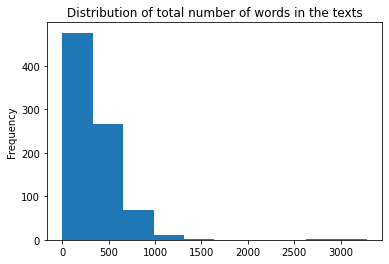

In [44]:
data.clean_text.apply(lambda x: len(x.split())).plot.hist()
plt.title("Distribution of total number of words in the texts")
plt.show()

In [ ]:
#data.to_csv("clinical_notes_cleaned.csv",index=False)

### References for further reading

<strong> NLP overview - </strong> https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

<strong> Regular Expressions - </strong> https://regex101.com/ 

<strong> Spacy - </strong> https://spacy.io/usage/spacy-101

<strong> NLTK - </strong> https://www.nltk.org/book/

